In [1688]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
events_raw = np.loadtxt(path + "data/tum-vie/events_img_645_655.txt")
events_raw[:,0] *= 10e-6

In [810]:
events_ref = flt.filter_refract(events_raw, 0.05)

In [811]:
events_ref.shape

(7687271, 4)

In [1483]:
start_time = events_ref[0,0]
duration = 1.0
events_t = flt.filter_time(events_ref, start_time, start_time+duration)

In [1484]:
events_ref[0]

array([331.71661, 117.     , 357.     ,   0.     ])

In [1722]:
patch_center = (320, 920)
patch_size = 720
# patch_center = (100, 480)
# patch_size = 100
shape = (patch_size, patch_size)
events = flt.filter_patch(events_t, patch_center, patch_size)

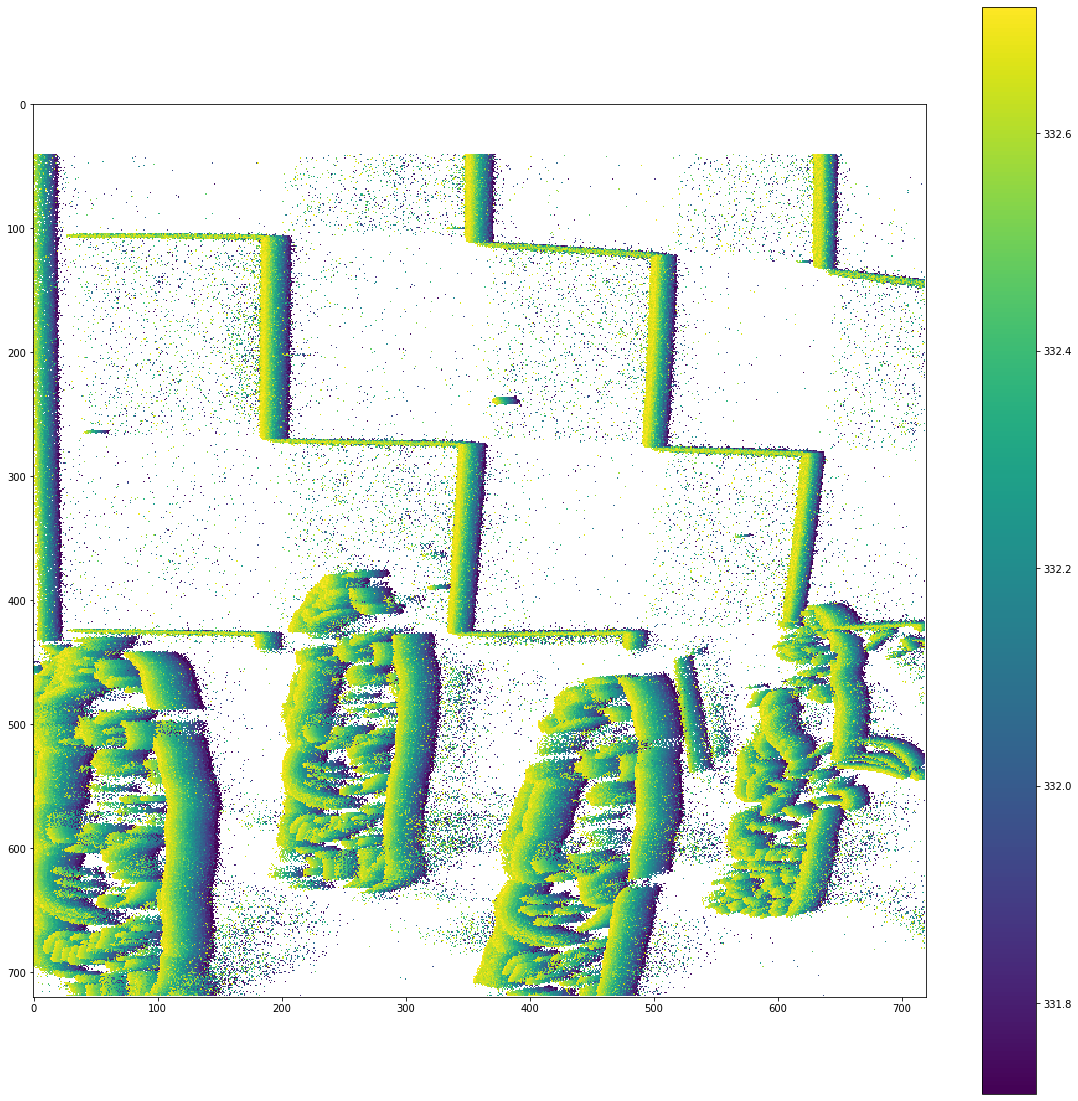

In [1723]:
%matplotlib inline
plt.figure(figsize=(20, 20))
img = vis.events2time_surf(events, shape, filter_polarity=True, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

In [1724]:
conv_shape = (5, 5)
conv_stride = (5, 5)
thresh = 2.0 / 3.0
result_shape = (int(shape[0]/conv_stride[0]), int(shape[1]/conv_stride[1]))
conv_acc = np.zeros(result_shape)
event_conv = []
for e in events:
#     if e[3] == 0:
#         continue
    
    x = int(e[1] / conv_stride[0])
    y = int(e[2] / conv_stride[1])
    
    conv_acc[y, x] += 1 if e[3]==1 else -1
    
    if np.abs(conv_acc[y, x]) >= conv_shape[0]*conv_shape[1] * thresh:
        event_conv.append([e[0], x, y, e[3]])
        conv_acc[y, x] = 0
        
event_conv = np.array(event_conv)

In [1725]:
events = flt.filter_refract(event_conv, 1.1)
shape = result_shape

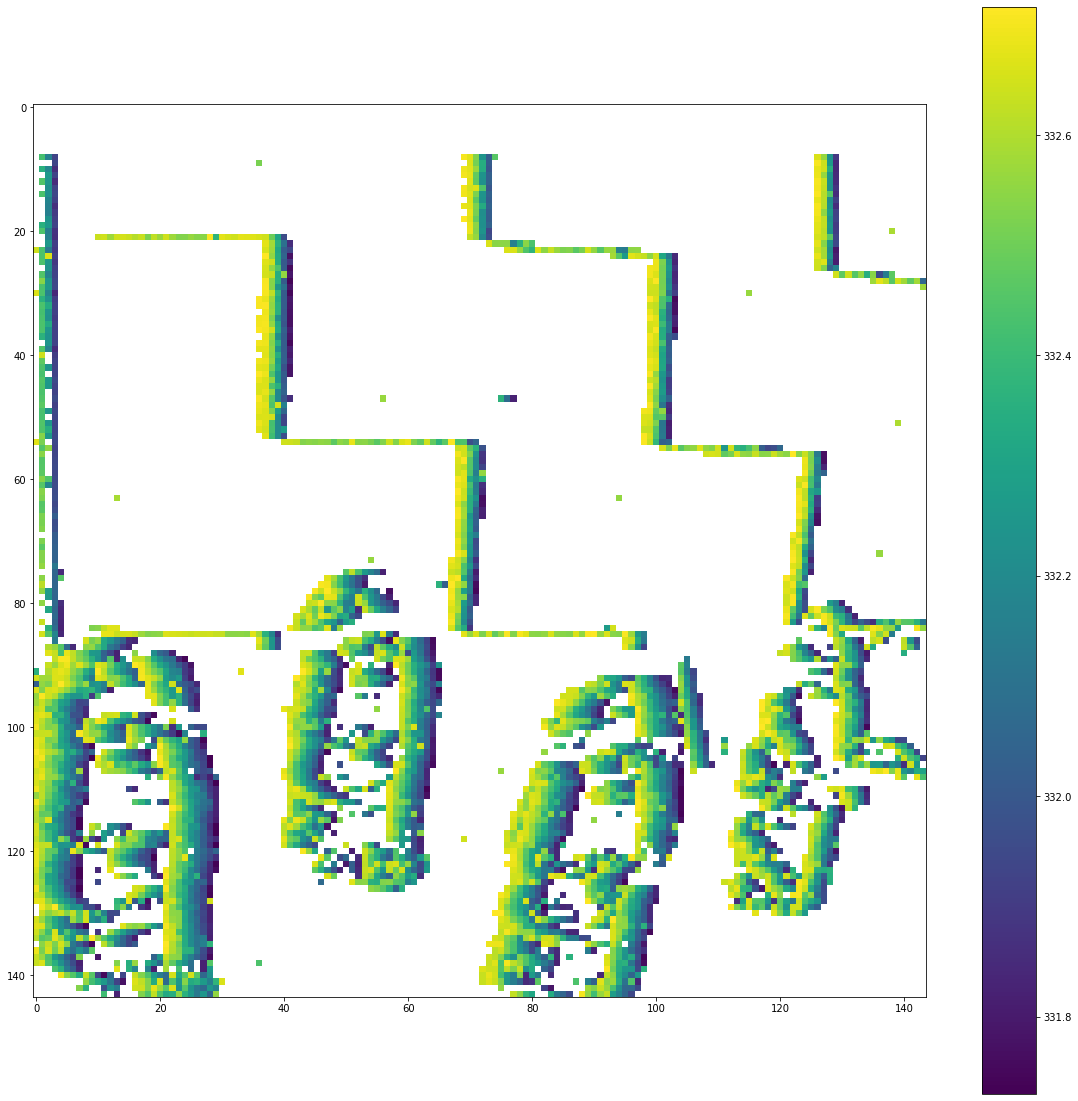

In [1726]:
%matplotlib inline
plt.figure(figsize=(20, 20))
img = vis.events2time_surf(event_conv, result_shape, filter_polarity=True, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
plt.colorbar(mappable=m)

In [1727]:
last_time = np.full(shape, -1.0)
dist = 1
td_predictions = {}
predictions = {}
px_range_pred = 5
event_sign = np.full(shape, -1)

angles = []

U = np.zeros(shape)
V = np.zeros(shape)
ofs = np.zeros(shape)

final_td = np.zeros(shape)

count = 0
discarded_neg = 0
discarded_dif = 0
discarded_q = 0
discarded_img = 0
discarded_ind = 0
discarded_ang = 0

for e in tqdm(events):
    x = int(e[1])
    y = int(e[2])
    
#     if e[3] == 1:
#         continue
    count += 1
    
    last_sign = event_sign[y, x]
    last_time[y, x] = e[0]
    event_sign[y, x] = e[3]
    
    u_td = (e[0] - last_time[y-dist, x] 
            if y-dist >= 0 and last_time[y-dist, x] != -1.0 and event_sign[y-dist, x] == e[3]
            else -1.0)
    d_td = (e[0] - last_time[y+dist, x] 
            if y+dist<shape[0] and last_time[y+dist, x] != -1.0 and event_sign[y+dist, x] == e[3]
            else -1.0)
    r_td = (e[0] - last_time[y, x+dist] 
            if x+dist < shape[1] and last_time[y, x+dist] != -1.0 and event_sign[y, x+dist] == e[3]
            else -1.0)
    l_td = (e[0] - last_time[y, x-dist] 
            if x-dist >= 0 and last_time[y, x-dist] != -1.0 and event_sign[y, x-dist] == e[3]
            else -1.0)
    
    #get camera direction
#     id_direction = np.searchsorted(gt[:,0], e[0])
# #     print(id_direction)
#     direction = directions[id_direction] - np.pi
#     direction = np.mod(direction, 2*np.pi)
    direction = np.pi# - np.pi/32
    #     print(np.rad2deg(direction))
    
#     if 0.0 <= direction < np.pi/2:
#         v_td = d_td
#         h_td = l_td
#     elif np.pi/2 <= direction < np.pi:
#         v_td = d_td
#         h_td = -r_td
#     elif np.pi <= direction < (3/2)*np.pi:
#         v_td = -u_td
#         h_td = -r_td
#     elif (3/2)*np.pi <= direction < 2*np.pi:
#         v_td = -u_td
#         h_td = l_td
    
#     v_td = -u_td if not np.isnan(u_td) else d_td
#     h_td = -r_td if not np.isnan(r_td) else l_td

#     h_td = h_td if not np.isnan(h_td) else 0
#     v_td = v_td if not np.isnan(v_td) else 0

#     U[y, x] = h_td #if not np.isnan(h_td) else 0
#     V[y, x] = v_td #if not np.isnan(v_td) else 0
    
#     if np.isnan(v_td) or np.isnan(h_td):
#         continue

    if u_td <= 0.0:
        if d_td <= 0.0:
            #discarded_neg += 1
            v_td = 0.0
        else:
            v_td = d_td
    else:
        if d_td > 0:
            v_td = d_td if d_td >= u_td else -u_td
            discarded_ind += 1
            continue
        else:
            v_td = -u_td
            
    if r_td <= 0.0:
        if l_td <= 0.0:
            #discarded_neg += 1
            h_td = 0.0
        else:
            h_td = l_td
    else:
        if l_td > 0:
            h_td = l_td if l_td >= r_td else -r_td
            discarded_ind += 1
            continue
        else:
            h_td = -r_td
            
    #v_td = 0.0
    if r_td > 0.0:
        h_td = -r_td
    else:
        continue
    
    
    m = np.sqrt(np.square(v_td) + np.square(h_td))
    a = np.abs(direction - np.mod(np.arctan2(v_td, h_td), np.pi*2))
    #a = np.mod(a, 2*np.pi)
    
#     if a > np.pi /2 :
#         continue
    
    angles.append(a)
    
    of = m * np.cos(a)
    ofs[y, x] = of
    time_difference = of / dist
    #print(a)
    if a > np.pi/2:
        discarded_ang += 1
        continue
    
    if (y, x) in td_predictions and len(td_predictions[y, x]) > 5:
        mean_pred = np.mean(td_predictions[y, x])
        std_pred = np.std(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 2*std_pred:
            last_time[y, x] = -1.0
            event_sign[y, x] = last_sign
            discarded_dif += 1
            continue
        if np.abs(mean_pred - time_difference) > 1.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            discarded_q += 1
            continue
        if e[0] > start_time + duration -0.22:
            final_td[y, x] = mean_pred
            
        U[y, x] = np.cos(direction) * time_difference
        V[y, x] = np.sin(direction) * time_difference

    #     U[y, x] = h_td
    #     V[y, x] = v_td
            
    td_predictions[y, x] = []
    a = direction
    
   
    
    for i in range(1, px_range_pred +1):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
            x_p = int(x + np.cos(a)*i + np.sin(a)*k)
            y_p = int(y + np.sin(a)*i - np.cos(a)*k)
            
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or x_p >= shape[1] or y_p < 0 or y_p >= shape[0]:
                discarded_img += 1
                continue
            
            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]

100%|██████████████████████████████████████████████████████████████████████████| 11042/11042 [00:01<00:00, 8758.79it/s]


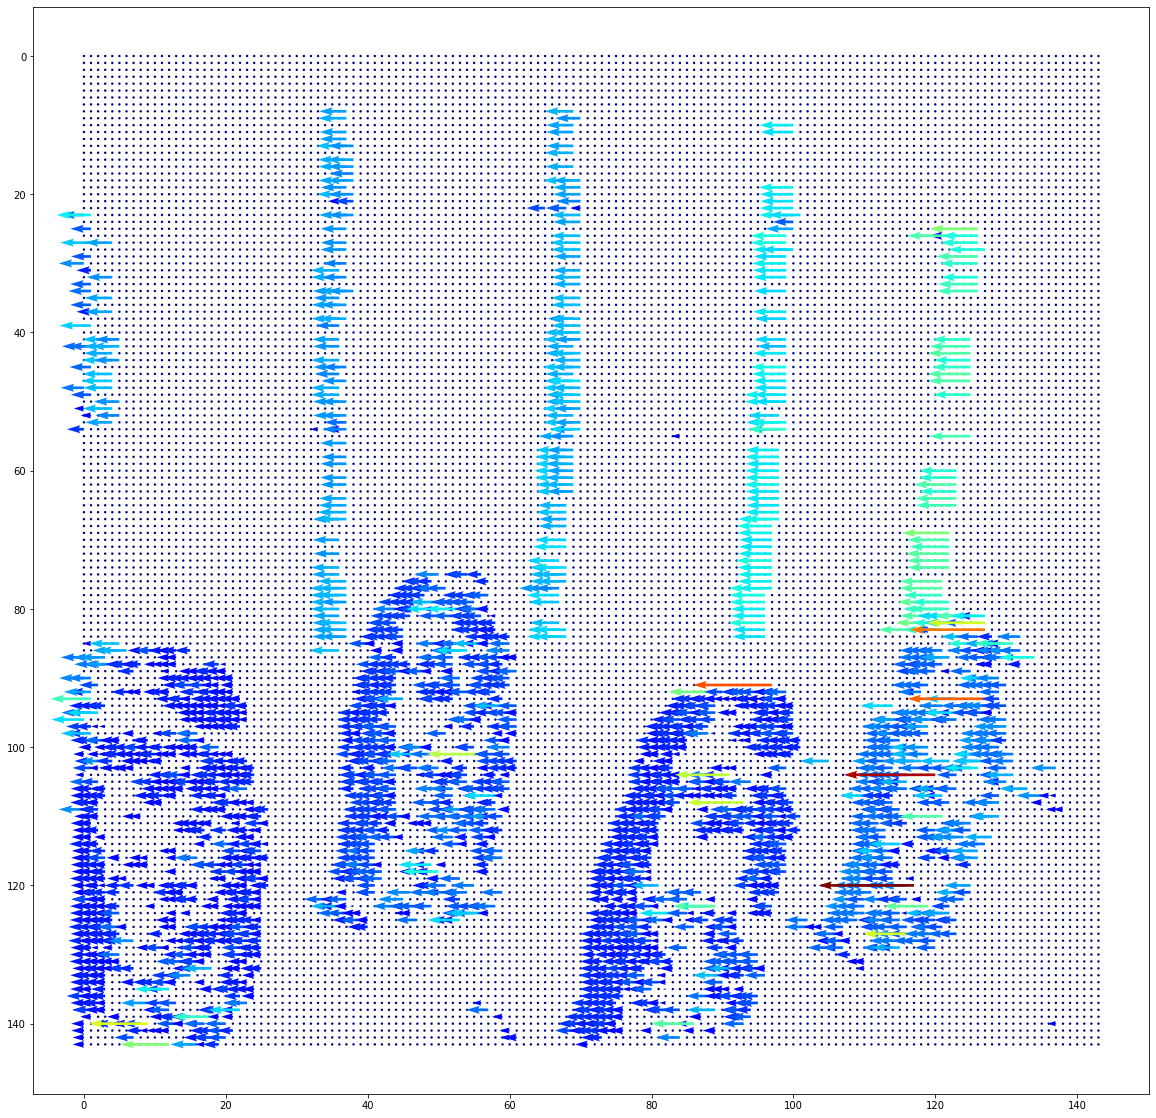

In [1728]:
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.quiver(U, V, U, scale =10, cmap="jet_r")
plt.gca().invert_yaxis()

In [1744]:
final_td, td_predictions, U, V = td2d.compute_time_difference(events, shape, delay=0.8)

100%|█████████████████████████████████████████████████████████████████████████| 11042/11042 [00:00<00:00, 18785.05it/s]


In [1745]:
plt.figure(figsize=(10, 10))
m = plt.imshow(U)
plt.colorbar(m)

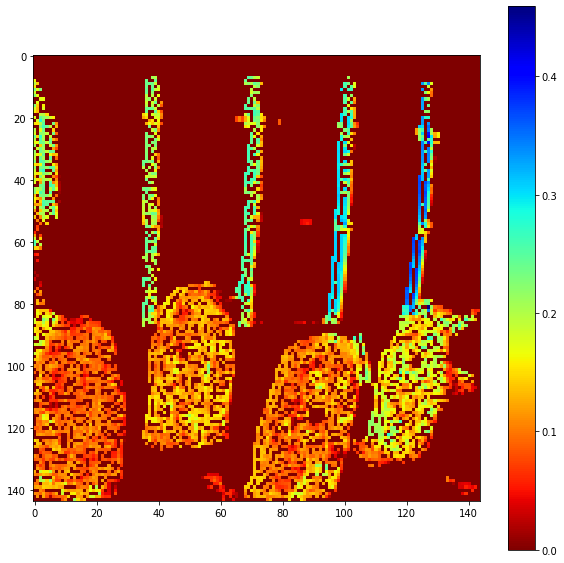

In [1760]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 5)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r", interpolation="none")
plt.colorbar(m)

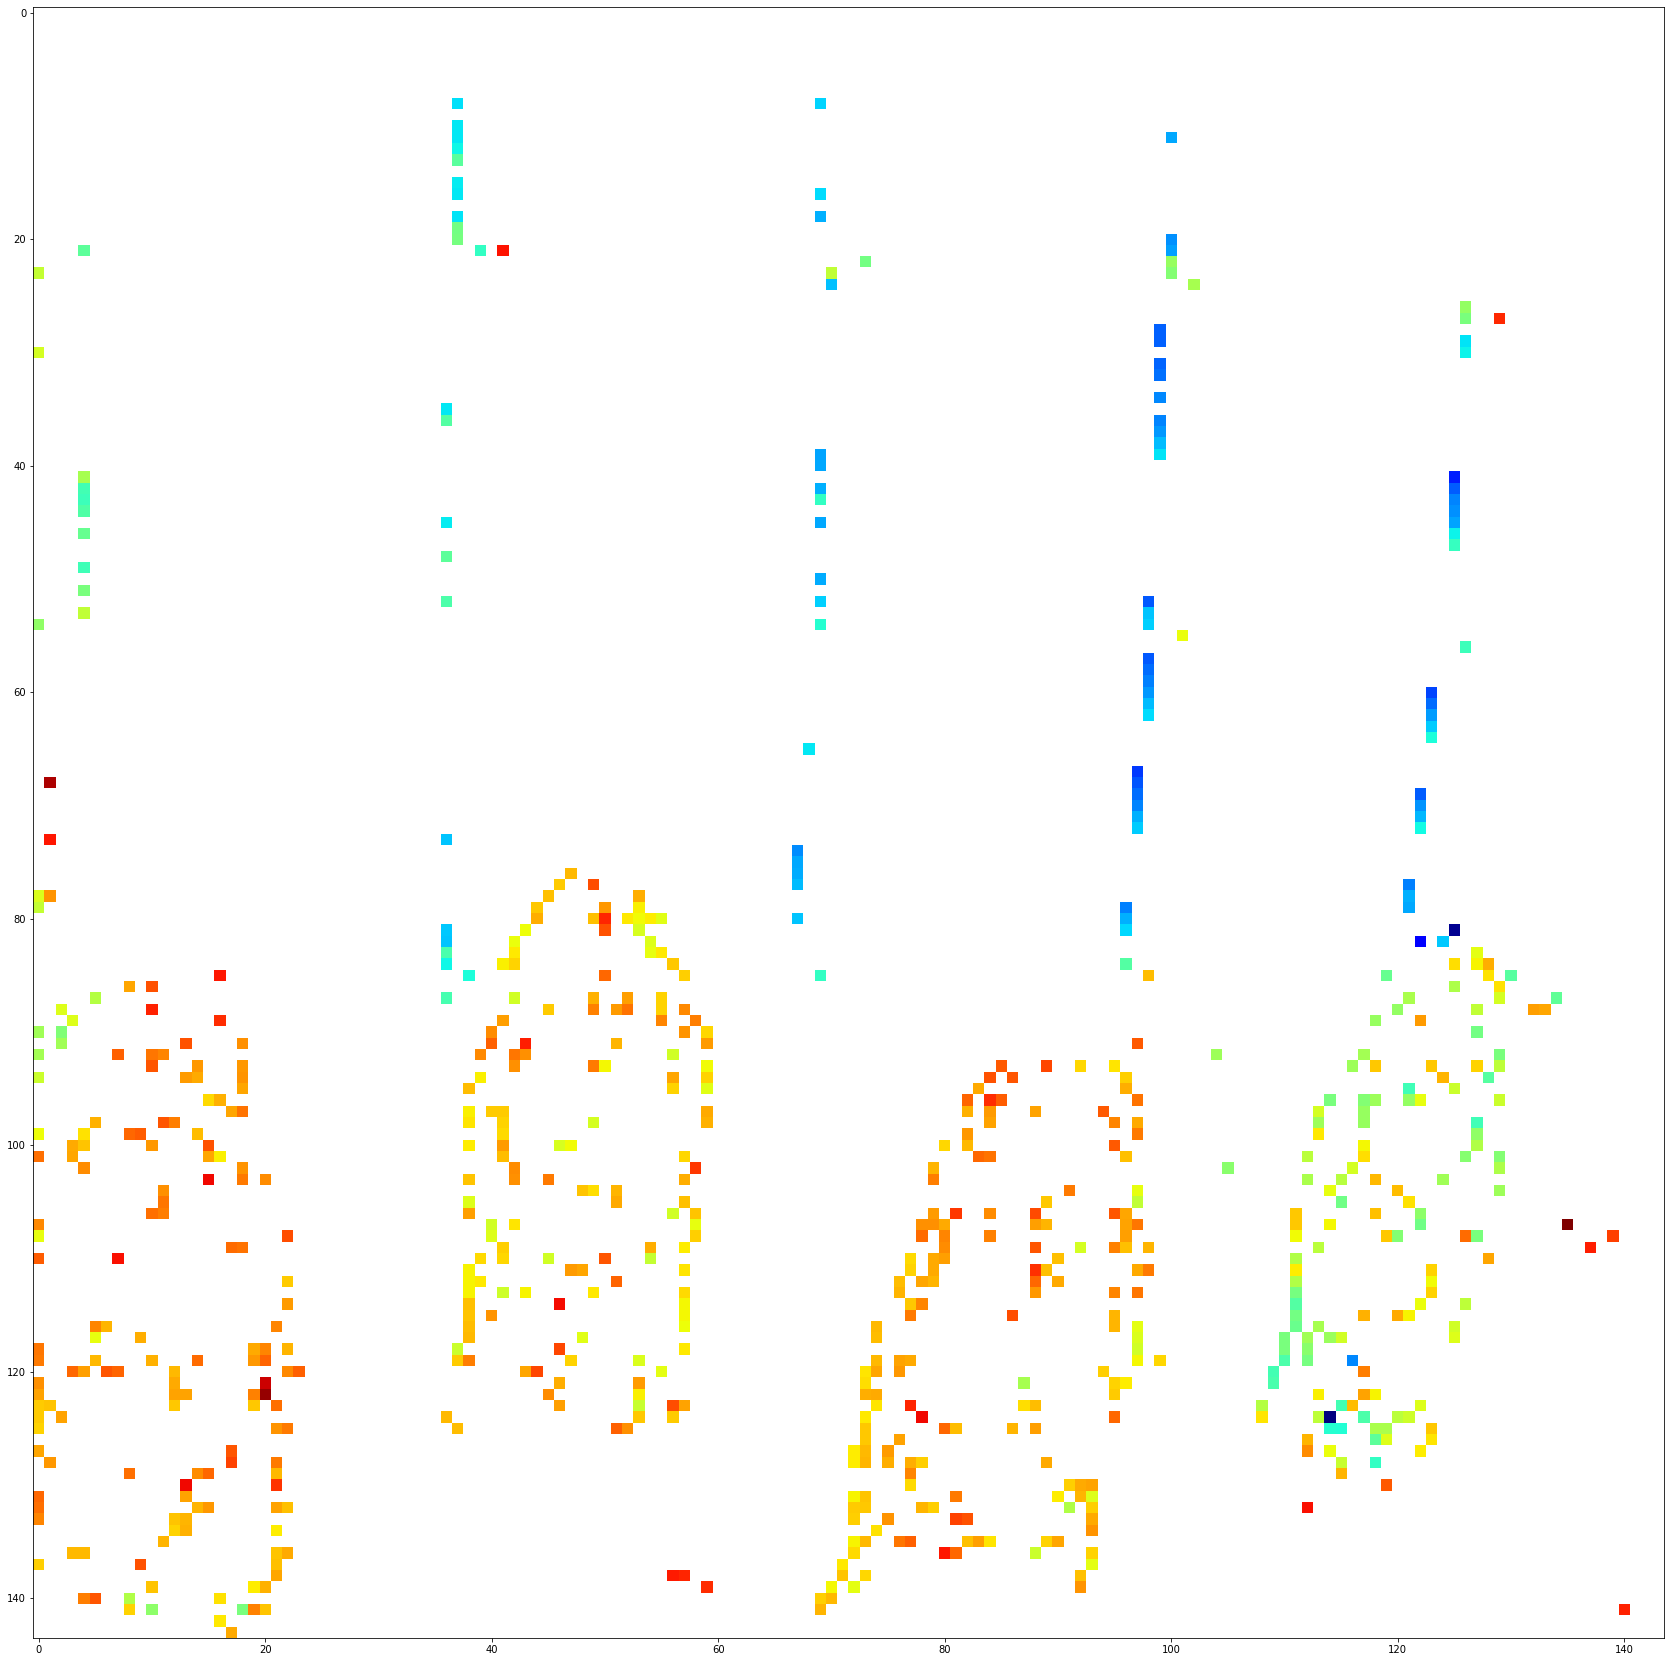

In [1766]:
plt.figure(figsize=(30, 30))
#img_gray = plt.imread(path + "data/slider-depth/images/frame_00000051.png")
final_td_m = np.ma.masked_where(final_td == 0, final_td)
#plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(final_td_m, cmap="jet_r", interpolation="none")
# plt.colorbar(m)

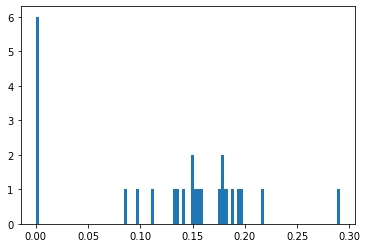

In [1762]:
px = np.unravel_index(count.argmax(), shape)
plt.hist(td_predictions[px], 100);

In [1763]:
u = np.divide(1.0, final_td_m, where=final_td!=0.0)

In [1764]:
d = td.v2depth(u, 2.0, 200.0)

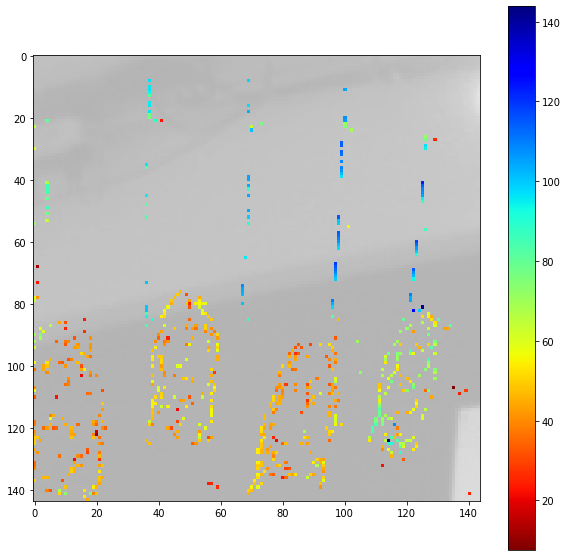

In [1765]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + "data/tum-vie/mocap-1d-trans-vi_gt_data/left_images/00645.jpg")
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [1752]:
%matplotlib qt
vis.visualize3d(d)

In [1753]:
points = vis._image2pointcloud(d)

In [1754]:
calib = np.loadtxt(path + "/data/slider-depth/calib.txt")
# gt = np.loadtxt(path + "/data/slider-depth/groundtruth.txt")
# idx = np.searchsorted(gt[:, 0], start_time)
pose = pose = np.array([0, 0, 0, 0, 0, 0, 0, 1])

In [1755]:
proj = td.project3d(points, calib, pose)

In [1756]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 1], proj[:, 2], s=2, c=proj[:, 2], cmap="jet_r")
#ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [1757]:
#proj = proj[proj[:,2]]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3])

In [1758]:
o3d.visualization.draw_geometries([pcd])

In [1658]:
last_time = np.full(shape, -1.0)
dist = 1
td_predictions = {}
predictions = {}
px_range_pred = 5
event_sign = np.full(shape, -1)

angles = []

U = np.zeros(shape)
V = np.zeros(shape)
ofs = np.zeros(shape)

final_td = np.zeros(shape)

count = 0
discarded_neg = 0
discarded_dif = 0
discarded_q = 0
discarded_img = 0
discarded_ind = 0
discarded_ang = 0

for e in tqdm(events):
    x = int(e[1])
    y = int(e[2])
    
#     if e[3] == 1:
#         continue
    count += 1
    
    last_sign = event_sign[y, x]
    last_time[y, x] = e[0]
    event_sign[y, x] = e[3]
    
    u_td = (e[0] - last_time[y-dist, x] 
            if y-dist >= 0 and last_time[y-dist, x] != -1.0 and event_sign[y-dist, x] == e[3]
            else -1.0)
    d_td = (e[0] - last_time[y+dist, x] 
            if y+dist<shape[0] and last_time[y+dist, x] != -1.0 and event_sign[y+dist, x] == e[3]
            else -1.0)
    r_td = (e[0] - last_time[y, x+dist] 
            if x+dist < shape[1] and last_time[y, x+dist] != -1.0 and event_sign[y, x+dist] == e[3]
            else -1.0)
    l_td = (e[0] - last_time[y, x-dist] 
            if x-dist >= 0 and last_time[y, x-dist] != -1.0 and event_sign[y, x-dist] == e[3]
            else -1.0)
    
    #get camera direction
#     id_direction = np.searchsorted(gt[:,0], e[0])
# #     print(id_direction)
#     direction = directions[id_direction] - np.pi
#     direction = np.mod(direction, 2*np.pi)
    direction = np.pi# - np.pi/32
    #     print(np.rad2deg(direction))
    
#     if 0.0 <= direction < np.pi/2:
#         v_td = d_td
#         h_td = l_td
#     elif np.pi/2 <= direction < np.pi:
#         v_td = d_td
#         h_td = -r_td
#     elif np.pi <= direction < (3/2)*np.pi:
#         v_td = -u_td
#         h_td = -r_td
#     elif (3/2)*np.pi <= direction < 2*np.pi:
#         v_td = -u_td
#         h_td = l_td
    
#     v_td = -u_td if not np.isnan(u_td) else d_td
#     h_td = -r_td if not np.isnan(r_td) else l_td

#     h_td = h_td if not np.isnan(h_td) else 0
#     v_td = v_td if not np.isnan(v_td) else 0

#     U[y, x] = h_td #if not np.isnan(h_td) else 0
#     V[y, x] = v_td #if not np.isnan(v_td) else 0
    
#     if np.isnan(v_td) or np.isnan(h_td):
#         continue

    if u_td <= 0.0:
        if d_td <= 0.0:
            #discarded_neg += 1
            v_td = 0.0
        else:
            v_td = d_td
    else:
        if d_td > 0:
            v_td = d_td if d_td >= u_td else -u_td
            discarded_ind += 1
            continue
        else:
            v_td = -u_td
            
    if r_td <= 0.0:
        if l_td <= 0.0:
            #discarded_neg += 1
            h_td = 0.0
        else:
            h_td = l_td
    else:
        if l_td > 0:
            h_td = l_td if l_td >= r_td else -r_td
            discarded_ind += 1
            continue
        else:
            h_td = -r_td
            
    #v_td = 0.0
    if r_td > 0.0:
        h_td = -r_td
    else:
        continue
    
    
    m = np.sqrt(np.square(v_td) + np.square(h_td))
    a = np.abs(direction - np.mod(np.arctan2(v_td, h_td), np.pi*2))
    #a = np.mod(a, 2*np.pi)
    
#     if a > np.pi /2 :
#         continue
    
    angles.append(a)
    
    of = m * np.cos(a)
    #of = h_td * np.cos(direction) + v_td * np.sin(direction)
    ofs[y, x] = of
    time_difference = of / dist
    #print(a)
    if a > np.pi/2:
        discarded_ang += 1
        continue
    
    if (y, x) in td_predictions and len(td_predictions[y, x]) > 5:
        mean_pred = np.mean(td_predictions[y, x])
        std_pred = np.std(td_predictions[y, x])
        
        if 0.1 > np.abs(mean_pred - time_difference) > 2*std_pred:
            last_time[y, x] = -1.0
            event_sign[y, x] = last_sign
            discarded_dif += 1
            continue
        if np.abs(mean_pred - time_difference) > 1.1:
            td_predictions[y, x] = []
            predictions[y, x] = []
            discarded_q += 1
            continue
        if e[0] > start_time + duration -0.22:
            final_td[y, x] = mean_pred
            
        U[y, x] = np.cos(direction) * time_difference
        V[y, x] = np.sin(direction) * time_difference

    #     U[y, x] = h_td
    #     V[y, x] = v_td
            
    td_predictions[y, x] = []
    a = direction
    
    
    
    for i in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
        for k in range(-int(px_range_pred / 2), int(px_range_pred / 2)):
#             x_p = int(x + np.cos(a)*i + np.sin(a)*k)
#             y_p = int(y + np.sin(a)*i - np.cos(a)*k)
            x_p = x + i
            y_p = y + k
        
            pred_time = last_time[y, x] + time_difference * i

            if x_p < 0 or x_p >= shape[1] or y_p < 0 or y_p >= shape[0]:
                discarded_img += 1
                continue
            
            if (y_p, x_p) in predictions:
                predictions[y_p, x_p].append(pred_time)
                td_predictions[y_p, x_p].append(time_difference)
            else:
                predictions[y_p, x_p] = [pred_time]
                td_predictions[y_p, x_p] = [time_difference]

100%|█████████████████████████████████████████████████████████████████████████| 11058/11058 [00:00<00:00, 19911.09it/s]


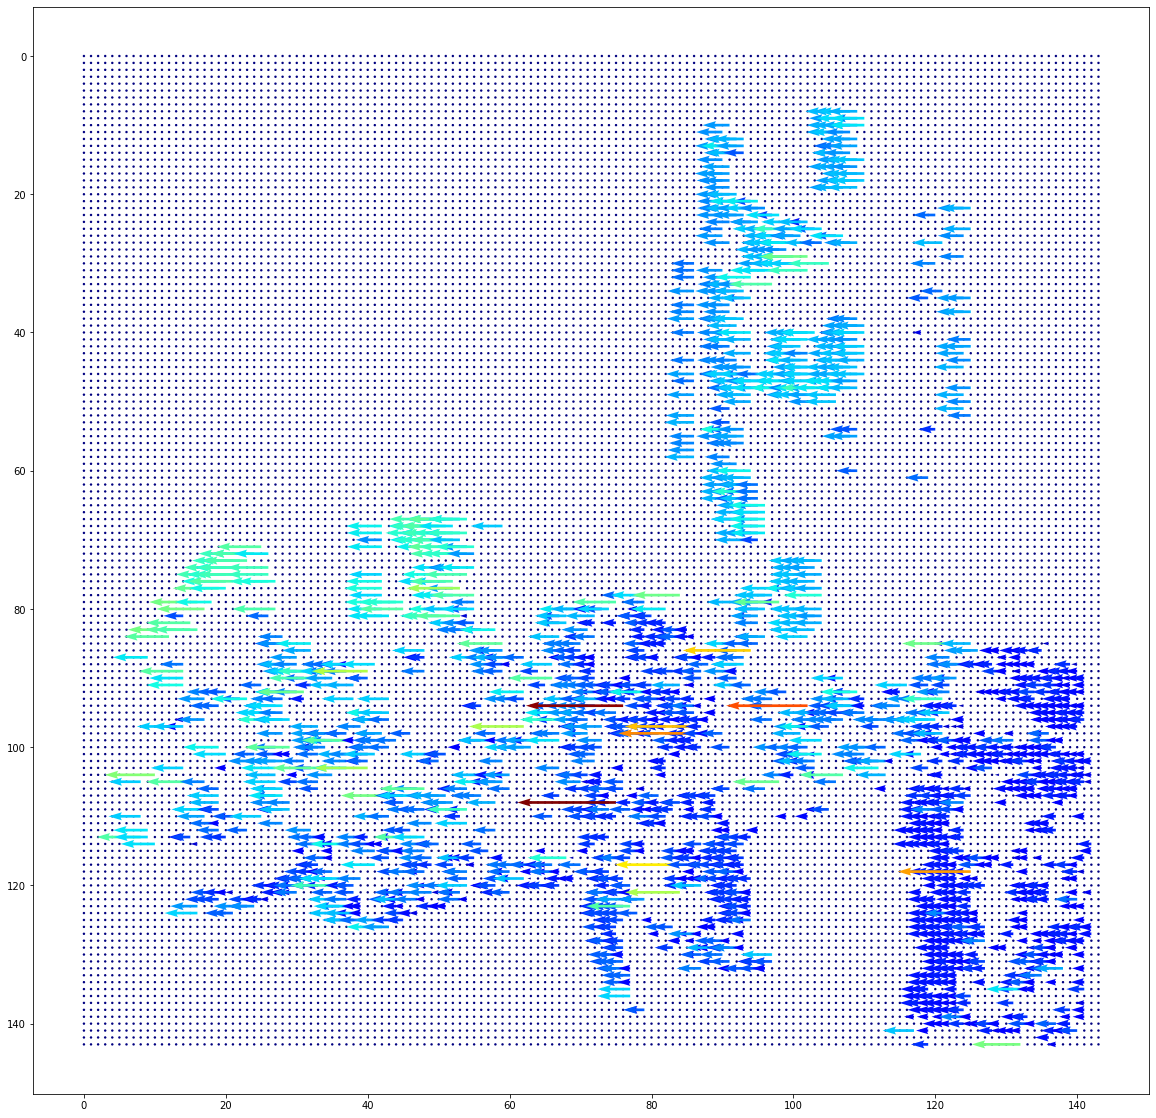

In [1659]:
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.quiver(U, V, U, scale =10, cmap="jet_r")
plt.gca().invert_yaxis()

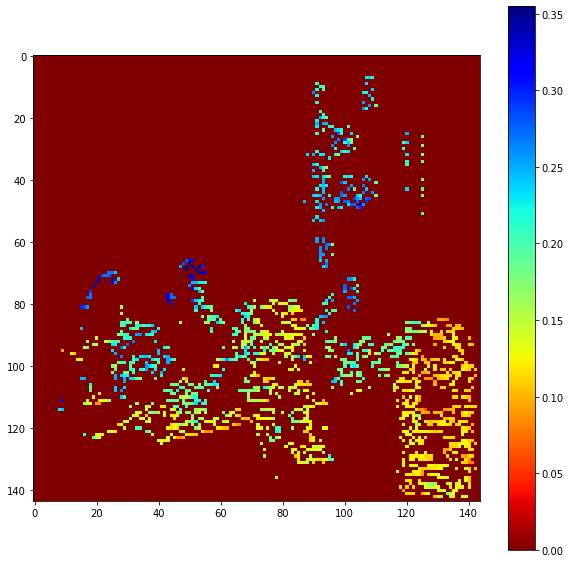

In [1653]:
%matplotlib inline
img, count = td.mean_from_dict(td_predictions, shape, 10)

plt.figure(figsize=(10, 10))
m = plt.imshow(img, cmap="jet_r", interpolation="none")
plt.colorbar(m)

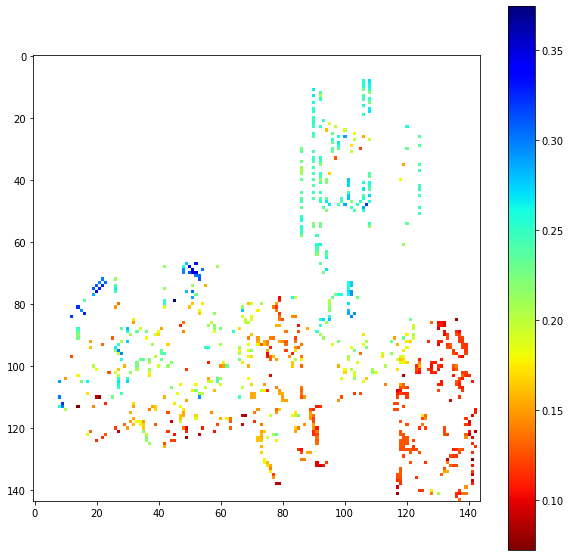

In [1654]:
plt.figure(figsize=(10, 10))
#img_gray = plt.imread(path + "data/slider-depth/images/frame_00000051.png")
final_td_m = np.ma.masked_where(final_td <= 0, final_td)
final_td = final_td_m
#plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(final_td_m, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [1655]:
u = np.divide(1.0, final_td, where=final_td>0.0)

In [1656]:
d = td.v2depth(u, 0.1, 20.0)

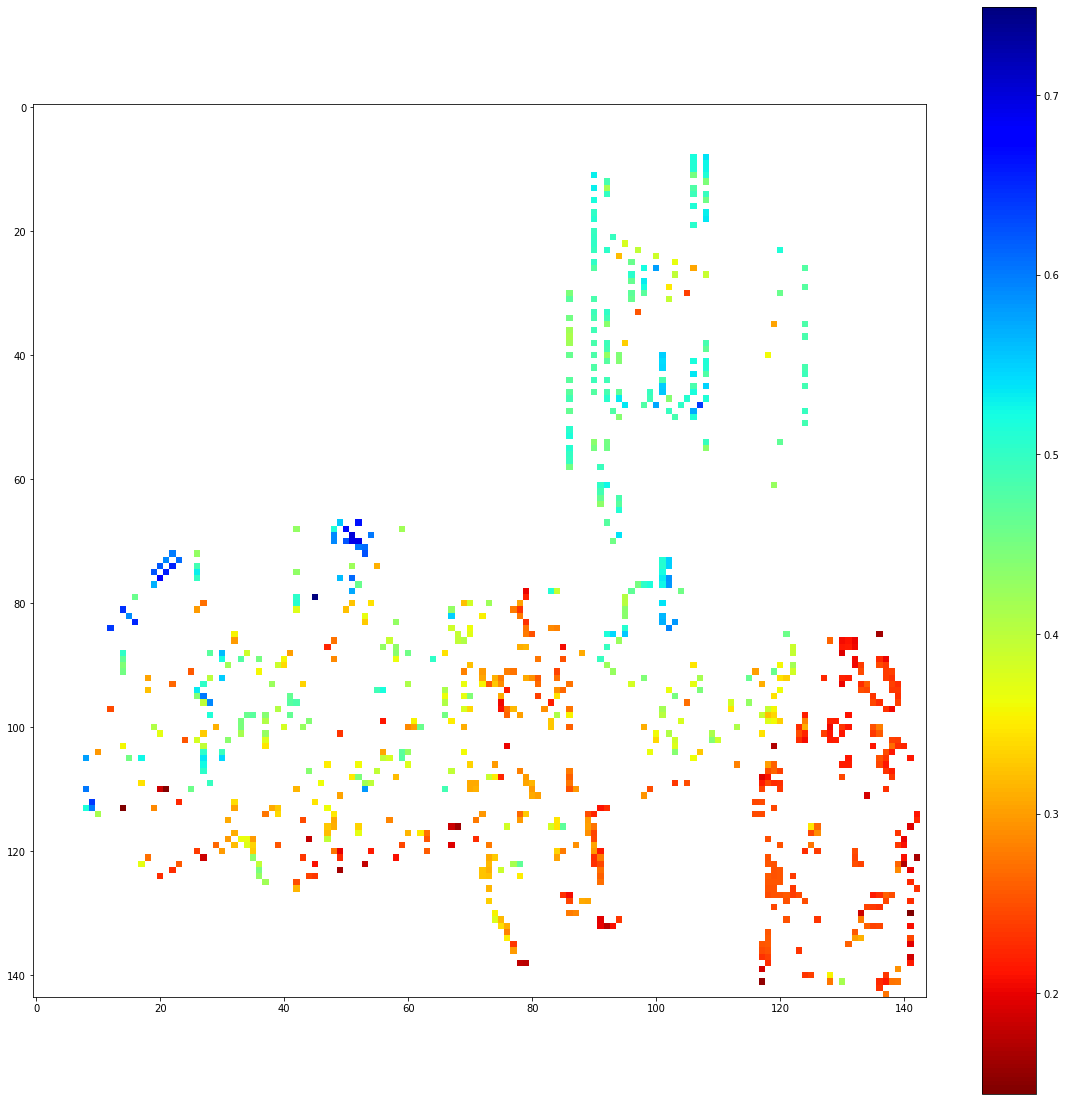

In [1657]:
plt.figure(figsize=(20, 20))
#plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(d, cmap="jet_r", interpolation="none")
plt.colorbar(m)

In [1626]:
%matplotlib qt
vis.visualize3d(d)

In [1628]:
np.rad2deg(np.arctan2(3, 1))

71.56505117707799

In [1634]:
b = np.pi / 2

In [1635]:
7 * np.cos(b) + 4 * np.sin(b)

4.0

In [1636]:
np.sqrt(4 + 6**2)

6.324555320336759

In [1675]:
t = np.linspace(0, 2*np.pi, 200)
ax = 10
ay = 9
p = np.arctan2(ay, ax)
r1 = np.sqrt(ax**2 + ay**2) * np.cos(t - np.mod(p, np.pi * 2))
r2 = np.cos(t) * ax + np.sin(t)*ay

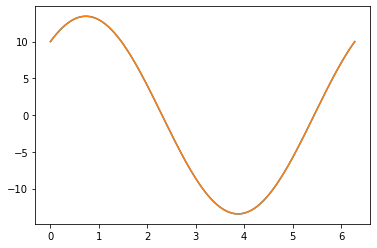

In [1676]:
plt.plot(t, r1)
plt.plot(t, r2)

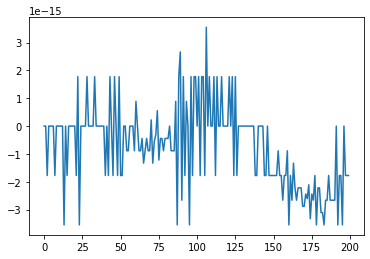

In [1677]:
plt.plot(r1 - r2)